### Simulations

A total of **64 2d wave simulations** with varying significant wave height (*Hs*) and peak period (*Tp*) have been conducted using my own implementation of [HOSim](https://github.com/VegardBaa/HOSim).

> *HOSim is a numerical wave simulation tool based on the High-Order Spectral (HOS) method. It allows for efficient simulation of nonlinear wave fields with customizable sea state parameters.*

The repository functions similarly to HOS-Ocean and is used here for simulating highly nonlinear wave fields. All training and evaluation data in this project have been generated using this tool, which has taken considerable time to develop and validate.

---

### Predictable Zone

The setup for this machine learning experiment involves a **3000-meter-long spatial domain** and **15 minutes of simulation** of highly nonlinear waves (Hs from 2.5-7.0m and Tp from 10-12s). The specific case used is illustrated in the figure below.

The predictable zone is defined based on a continuous measurement of the wave field over a duration of **T = 60 seconds**, within the spatial interval **x = 0 to x<sub>max</sub> = 2000 meters**.

As seen in the figure, using this measurement it becomes possible to make a prediction in the region **x = 2000 to 2700 meters** after a delay of approximately **140 seconds**. This defines the prediction task used in the machine learning setup.


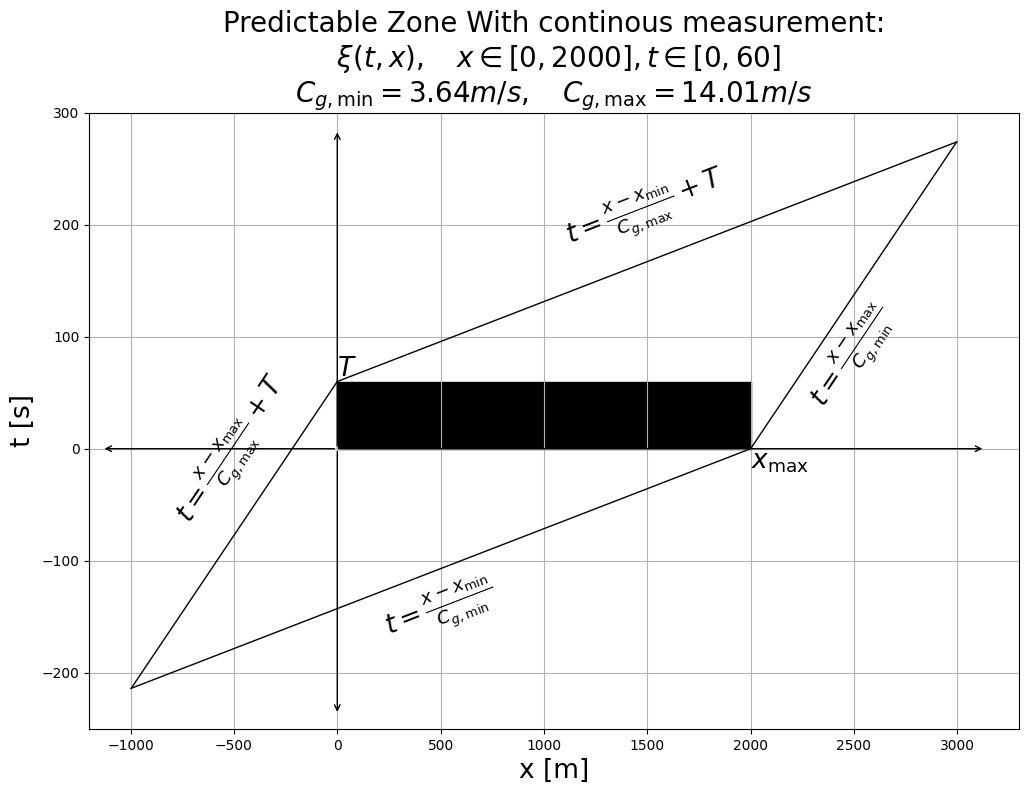

In [1]:
import matplotlib.pyplot as plt
import numpy as np

e_min = 0
e_max = 2000

c_min = 3.64
c_max = 14.01

T = 60

x_min = -1200
x_max = 3300
y_min = -250
y_max = 300

fontsize = 19

x1 = (e_min*c_max - c_min*e_max) / (c_max - c_min) - T * (c_max * c_min) / (c_max - c_min)
t1 = (x1 - e_max) / c_max

x2 = (e_max*c_max - c_min*e_min) / (c_max - c_min) + T * (c_max * c_min) / (c_max - c_min)
t2 = (x2 - e_max) / c_min

points_x = [T, t2, 0, t1, T]
points_y = [e_min, x2, e_max, x1, e_min]

box_x = [T, T, 0, 0] #T]
box_y = [e_min, e_max, e_max, e_min] #, e_min]

equations = [
    fr"$t=\frac{{x - x_{{\max}}}}{{c_{{g,\min}}}}$", 
    r"eq2", 
    r"eq3", 
    r"eq4"
]

equations = [
    fr"$t=\frac{{x - x_{{\min}}}}{{C_{{g,\max}}}} + T$",
    fr"$t = \frac{{x - x_{{\max}}}}{{C_{{g,\min}}}}$", 
    fr"$t = \frac{{x - x_{{\min}}}}{{C_{{g,\min}}}}$", 
    fr"$t=\frac{{x - x_{{\max}}}}{{C_{{g,\max}}}} + T$"
]

fig, ax = plt.subplots(figsize=(12, 8))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

ax = plt.gca()
transform = ax.transData.transform

for index in range(len(points_x)-1):
    x0, x1 = points_y[index], points_y[index+1]   # matplotlib x-coords
    y0, y1 = points_x[index], points_x[index+1]

    xm = (x0 + x1) / 2
    ym = (y0 + y1) / 2

    # compute angle in degrees for text rotation
    (x0_disp, y0_disp) = transform((x0, y0))
    (x1_disp, y1_disp) = transform((x1, y1))
    angle = np.degrees(np.arctan2(y1_disp - y0_disp, x1_disp - x0_disp))+[0, 180, 180, 0][index]

    # place the equation string
    plt.text(xm, ym, equations[index],
             rotation=angle,
             ha="center", va=["bottom", "top", "top", "bottom"][index],
             fontsize=fontsize)

    plt.plot([x0, x1], [y0, y1], color="k", linewidth=1)
    # plt.plot(box_y[index:index+2], box_x[index:index+2], color="k", linewidth=1)

plt.fill(box_y, box_x, color="k", linewidth=1)

plt.grid()
plt.title("Predictable Zone With continous measurement:\n" + fr" $\xi (t, x), \quad x \in [0, 2000], t \in [0, 60]$" + "\n" + fr"$C_{{g,\min}}={c_min:.2f}m/s, \quad C_{{g,\max}}={c_max:.2f}m/s$", fontsize=20)
plt.ylabel("t [s]", fontsize=fontsize)
plt.xlabel("x [m]", fontsize=fontsize)


# ax.spines['top'].set_visible(False) 
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.text(points_y[0], points_x[0], fr"$T$", ha="left", va="bottom", fontsize=fontsize)
plt.text(points_y[2], points_x[2], fr"$x_{{\max}}$", ha="left", va="top", fontsize=fontsize)
arrowOffset=10
ax.annotate('', xy=(x_max*0.95, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='black', lw=1))
ax.annotate('', xy=(0, y_max*0.95), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='black', lw=1))
ax.annotate('', xy=(x_min*0.95, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='black', lw=1))
ax.annotate('', xy=(0, y_min*0.95), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='black', lw=1))
plt.show()

# jupyter nbconvert ML_update.ipynb --to pdf --PDFExporter.preprocessors="['nbconvert.preprocessors.TagRemovePreprocessor']" --TagRemovePreprocessor.remove_input_tags="['hide_input']"

In [87]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

eta_hat, phi_hat, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None, None

with h5py.File("Z:\\files\\simulation.h5", "r") as data:
    eta_hat = data["eta_hat"][:]
    phi_hat = data["phi_hat"][:]
    Hs = data["Hs"][:]
    Tp = data["Tp"][:]
    time = data["time"][:]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

index = np.argmin(np.abs(time - 2*Ta))

eta_hat = eta_hat[:, index:, :]
phi_hat = phi_hat[:, index:, :]
time = time[index:] - time[index]

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from numpy.fft import irfft, rfft

cut_index = np.argmin(np.abs(x-2000))
cut_index_2 = np.argmin(np.abs(x-2700))+1

In [4]:
# Creating dataset

prediction_time = 280 # 140 sec
measure_time = 120 # one minute
num_measurements = 6
step = int(measure_time / num_measurements)

train_percentage = 0.7
batch_size = 32

X = eta_hat[0, :-prediction_time, :]
y = eta_hat[0, prediction_time+measure_time:, :]

X = irfft(X)
y = irfft(y)

X = X[:, :cut_index]
y = y[:, cut_index:cut_index_2]

# Create dataset using 6 measurements with 10 sec inbetween

X = np.stack([
    X[0*step:-measure_time+0*step-1],
    X[1*step:-measure_time+1*step-1],
    X[2*step:-measure_time+2*step-1],
    X[3*step:-measure_time+3*step-1],
    X[4*step:-measure_time+4*step-1],
    X[5*step:-measure_time+5*step-1],
    X[6*step:-measure_time+6*step-1],
], axis=1)

# Split into train and test

X_train = X[:int(X.shape[0]*train_percentage), :, :]
X_test = X[int(X.shape[0]*train_percentage):, :, :]
y_train = y[:int(y.shape[0]*train_percentage), :]
y_test = y[int(y.shape[0]*train_percentage):, :]

# Only need std to normalize 

std = np.std(X_train)
X_train = X_train / std
y_train = y_train / std

In [5]:
# X_hat = np.fft.rfft(X)
# X = np.concatenate((np.real(X_hat), np.imag(X_hat)), axis=-1)

# y_train_hat = np.fft.rfft(y)
# y_train = np.concatenate((np.real(y_train_hat), np.imag(y_train_hat)), axis=-1)

# y_pred = np.fft.irfft(y_pred[:, :y_pred.shape[-1]//2] + 1.j * y_pred[:, y_pred.shape[-1]//2:])

In [6]:
# Creating the model

inputs = keras.Input(shape=(X_train.shape[-2], X_train.shape[-1]))
x_ = layers.Flatten()(inputs)
x_ = layers.Dense(512, activation='relu')(x_)
x_ = layers.Dense(512, activation='relu')(x_)
outputs = layers.Dense(y_train.shape[-1])(x_)

model = keras.Model(inputs, outputs)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=1000,
    callbacks=[early_stopping],
    shuffle=True
)

y_pred = model.predict(X_test / std) * std

Epoch 1/1000
28/28 [==============================] - 2s 41ms/step - loss: 0.7592 - mae: 0.6794 - val_loss: 0.6232 - val_mae: 0.6255
Epoch 2/1000
28/28 [==============================] - 1s 21ms/step - loss: 0.4036 - mae: 0.5023 - val_loss: 0.5062 - val_mae: 0.5660
Epoch 3/1000
28/28 [==============================] - 1s 22ms/step - loss: 0.2959 - mae: 0.4309 - val_loss: 0.4539 - val_mae: 0.5340
Epoch 4/1000
28/28 [==============================] - 1s 20ms/step - loss: 0.2465 - mae: 0.3927 - val_loss: 0.4058 - val_mae: 0.5052
Epoch 5/1000
28/28 [==============================] - 1s 18ms/step - loss: 0.2016 - mae: 0.3557 - val_loss: 0.3757 - val_mae: 0.4880
Epoch 6/1000
28/28 [==============================] - 1s 21ms/step - loss: 0.1797 - mae: 0.3360 - val_loss: 0.3542 - val_mae: 0.4739
Epoch 7/1000
28/28 [==============================] - 1s 20ms/step - loss: 0.1492 - mae: 0.3060 - val_loss: 0.3415 - val_mae: 0.4645
Epoch 8/1000
28/28 [==============================] - 1s 20ms/step - 

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss ANN')
plt.show()

NameError: name 'history' is not defined

<Figure size 800x500 with 0 Axes>

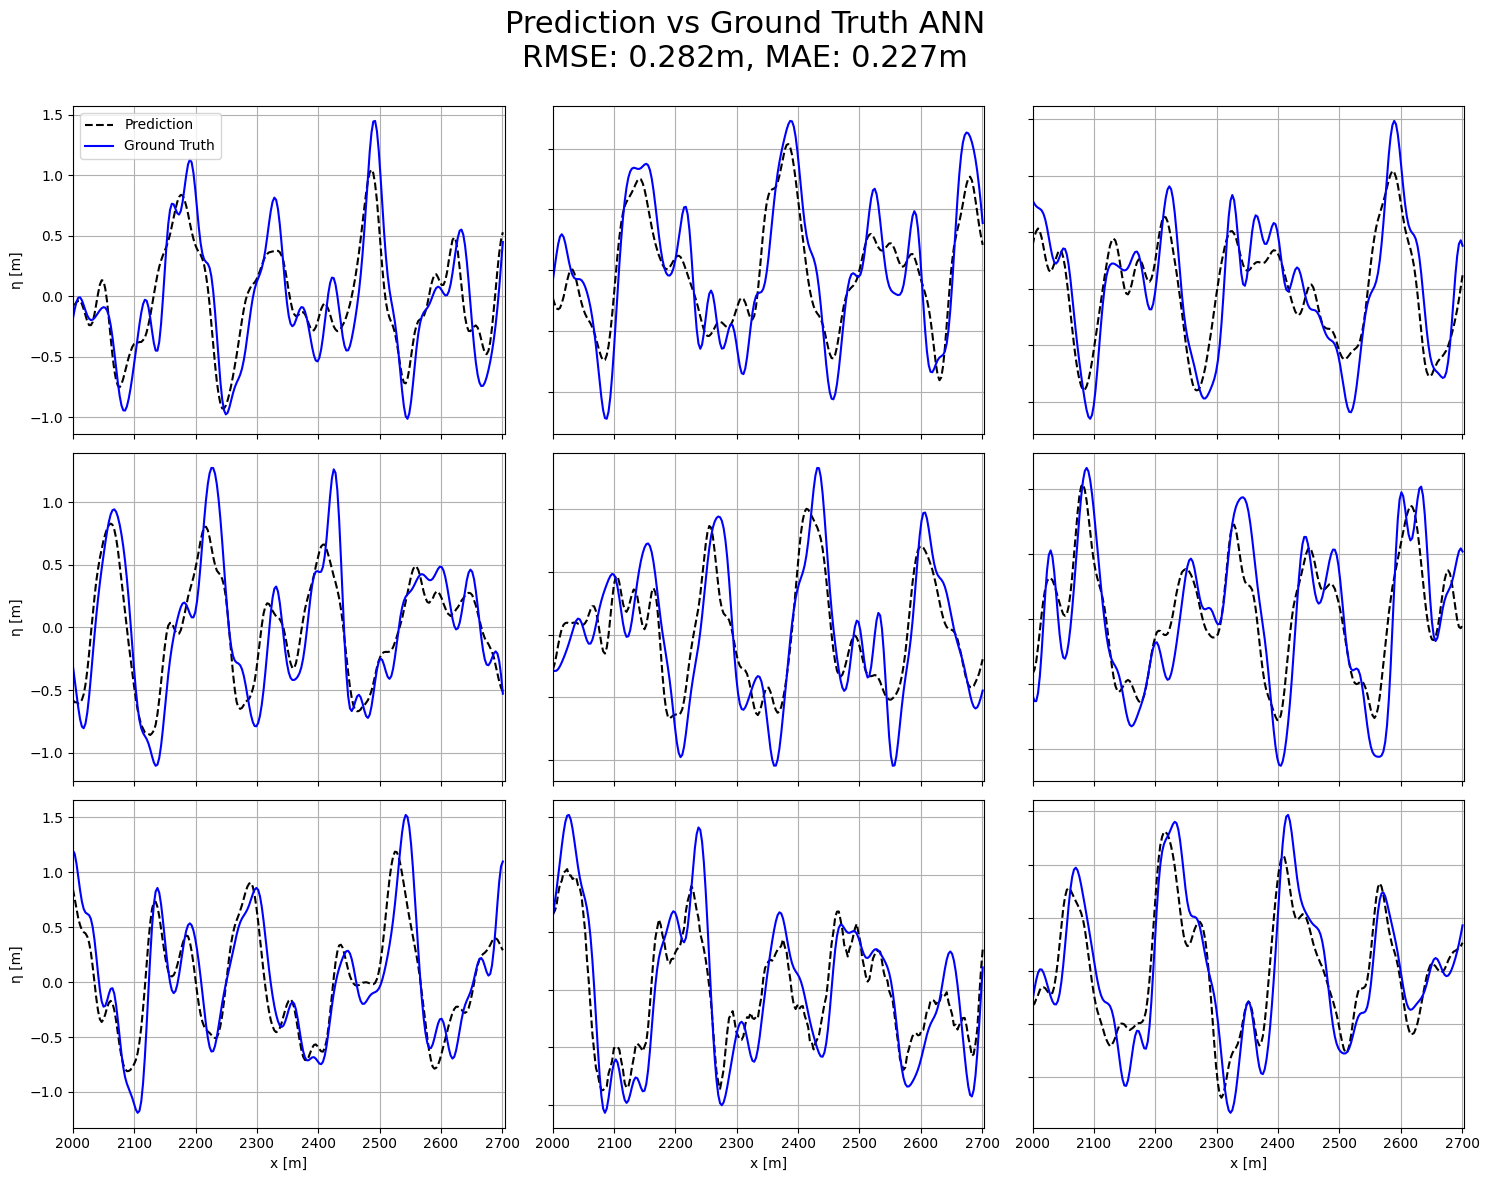

In [8]:
RMSE = np.sqrt(np.mean((y_pred - y_test)**2))
MAE = np.mean(np.abs(y_pred-y_test))

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Prediction vs Ground Truth ANN\n" + f"RMSE: {RMSE:.3f}m, MAE: {MAE:.3f}m", fontsize=22)

for i, ax in enumerate(axes.flat):
    ax.plot(x[cut_index:cut_index_2], y_pred[int(i/9*y_pred.shape[0]), :], label='Prediction', color="k", linestyle="--")
    ax.plot(x[cut_index:cut_index_2], y_test[int(i/9*y_pred.shape[0]), :], label='Ground Truth', color="b")
    ax.grid(True)

    ax.grid(True)

    row, col = divmod(i, 3)
    
    if row == 2:
        ax.set_xlabel('x [m]')
    else:
        ax.set_xticklabels([])
    if col == 0:
        ax.set_ylabel('η [m]')
    else:
        ax.set_yticklabels([])

    if i == 0:
        ax.legend()

    ax.set_xlim(x[cut_index], x[cut_index_2])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [88]:
# Creating dataset

prediction_time = 280 # 140 sec
measure_time = 120 # one minute
num_measurements = 6
step = int(measure_time / num_measurements)

train_percentage = 0.7
batch_size = 32

X = eta_hat[0, :-prediction_time, :]
y = eta_hat[0, prediction_time+measure_time:-1, :]

X = irfft(X)
y = irfft(y)

X[:, cut_index:] = 0

# Create dataset using 6 measurements with 10 sec inbetween

X = np.stack([
    X[0*step:-measure_time+0*step-1],
    X[1*step:-measure_time+1*step-1],
    X[2*step:-measure_time+2*step-1],
    X[3*step:-measure_time+3*step-1],
    X[4*step:-measure_time+4*step-1],
    X[5*step:-measure_time+5*step-1],
    X[6*step:-measure_time+6*step-1],
], axis=1)

# Split into train and test

X_train = X[:int(X.shape[0]*train_percentage), :, :]
X_test = X[int(X.shape[0]*train_percentage):, :, :]
y_train = y[:int(y.shape[0]*train_percentage), :]
y_test = y[int(y.shape[0]*train_percentage):, :]

# Only need std to normalize 

std = np.std(X_train)
X_train = X_train
y_train = y_train

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from FNO import FNO1d

device = torch.device("cuda")

# to PyTorch tensors
X_t = torch.from_numpy(X_train).float()
y_t = torch.from_numpy(y_train).float()

dataset = TensorDataset(X_t, y_t)
loader  = DataLoader(dataset, batch_size=32, shuffle=True)

model     = FNO1d(in_channels=num_measurements+1, out_channels=1, width=64, modes=512, depth=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

early_stopping_rounds = 5

early_stopping_count = 0
best_loss = np.inf

loss_mask = np.zeros(1024)
loss_mask[cut_index:cut_index_2] = 1
loss_mask = torch.tensor(loss_mask, dtype=torch.float32).to(device)

model.train()
for epoch in range(1, 101):
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)          # xb shape → (B, N) → model handles unsqueeze
        loss = criterion(pred*loss_mask, yb*loss_mask) * 1024.0 / torch.sum(loss_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(loader)

    if avg < best_loss:
        best_loss = avg
        early_stopping_count = 0
        torch.save(model.state_dict(), "best_FNO.pt")
        print(f"Saved new best model at epoch {epoch} with loss {avg:.6f}")
    else:
        early_stopping_count += 1
        if early_stopping_count > early_stopping_rounds:
            print("early_stopping")
            break

    print(f"Epoch {epoch:3d} — train MSE: {avg:.6f}")

Saved new best model at epoch 1 with loss 0.013110
Epoch   1 — train MSE: 0.013110
Saved new best model at epoch 2 with loss 0.000500
Epoch   2 — train MSE: 0.000500
Saved new best model at epoch 3 with loss 0.000121
Epoch   3 — train MSE: 0.000121
Saved new best model at epoch 4 with loss 0.000063
Epoch   4 — train MSE: 0.000063
Saved new best model at epoch 5 with loss 0.000044
Epoch   5 — train MSE: 0.000044
Saved new best model at epoch 6 with loss 0.000033
Epoch   6 — train MSE: 0.000033
Saved new best model at epoch 7 with loss 0.000025
Epoch   7 — train MSE: 0.000025
Saved new best model at epoch 8 with loss 0.000020
Epoch   8 — train MSE: 0.000020
Saved new best model at epoch 9 with loss 0.000017
Epoch   9 — train MSE: 0.000017
Saved new best model at epoch 10 with loss 0.000016
Epoch  10 — train MSE: 0.000016
Saved new best model at epoch 11 with loss 0.000014
Epoch  11 — train MSE: 0.000014
Saved new best model at epoch 12 with loss 0.000013
Epoch  12 — train MSE: 0.000013
S

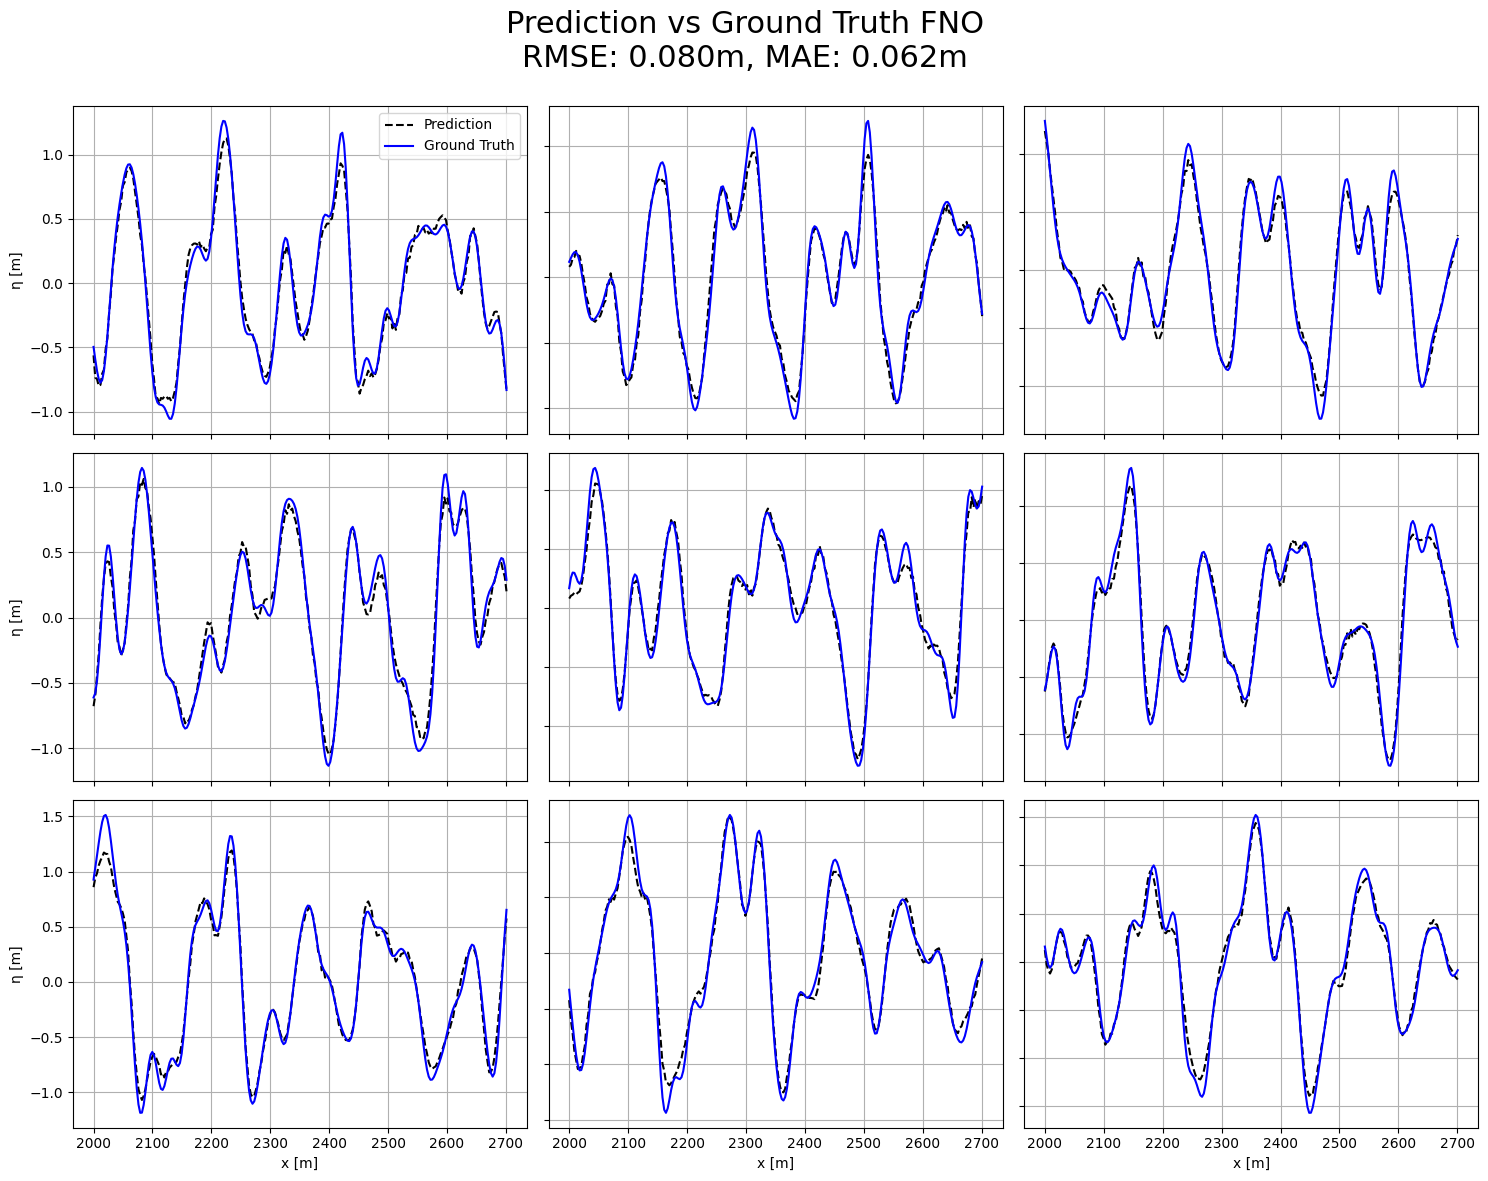

In [ ]:
model = FNO1d(in_channels=num_measurements+1, out_channels=1, width=64, modes=512, depth=3).to(device)
model.load_state_dict(torch.load("best_FNO.pt", map_location=device))
model.eval() 

X_tensor = torch.from_numpy(X_test / std).float().to(device)
y_pred = None
with torch.no_grad():
    y_pred = model(X_tensor)
    y_pred = y_pred.cpu().numpy() * std

y_pred_cut = y_pred[y_pred.shape[0]//3:]
y_test_cut = y_test[y_test.shape[0]//3:]

RMSE = np.sqrt(np.mean((y_pred_cut[:, cut_index:cut_index_2] - y_test_cut[:, cut_index:cut_index_2])**2))
MAE = np.mean(np.abs(y_pred_cut[:, cut_index:cut_index_2]-y_test_cut[:, cut_index:cut_index_2]))

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Prediction vs Ground Truth FNO\n" + f"RMSE: {RMSE:.3f}m, MAE: {MAE:.3f}m", fontsize=22)

for i, ax in enumerate(axes.flat):
    ax.plot(x[cut_index:cut_index_2], y_pred_cut[int(i/9*y_pred_cut.shape[0]), cut_index:cut_index_2], label='Prediction', color="k", linestyle="--")
    ax.plot(x[cut_index:cut_index_2], y_test_cut[int(i/9*y_pred_cut.shape[0]), cut_index:cut_index_2], label='Ground Truth', color="b")
    ax.grid(True)

    ax.grid(True)

    row, col = divmod(i, 3)
    
    if row == 2:
        ax.set_xlabel('x [m]')
    else:
        ax.set_xticklabels([])
    if col != 0:
        ax.set_ylabel('η [m]')

    if i == 0:
        ax.legend()

    ax.set_xlim(x[cut_index], x[cut_index_2])

    # ax.set_xlim(x[cut_index], x[cut_index_2])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [89]:
import jax
import jax.numpy as jnp

sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from HOSim import solver

f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6))
rk4_step_jit = jax.jit(solver.rk4_step, static_argnums=(2, 3, 4, 5, 6, 7, 8))
k = np.arange(0, X_train.shape[-1]//2+1) * 2 * np.pi / length
g = 9.81

L1 = np.ones(X_train.shape[-1]//2)*2
L1 = np.insert(L1, 0, 0)

L2 = 1.0 / (np.arange(1, X_train.shape[-1]//2+1) * 2 * np.pi / length) - g
L2 = np.insert(L2, 0, 0)

# for index in range(X_train.shape[0]):

index = 0

eta_0 = X_train[index, 0, :]
eta_hat_0 = rfft(eta_0)
phi_hat_0 = eta_hat_0[1:] * np.exp(-1.j * np.pi / 2) * np.sqrt(g / k[1:])
phi_hat_0 = np.insert(phi_hat_0, 0, 0)

y_hat = jnp.asarray(np.concatenate((eta_hat_0, phi_hat_0)), dtype=jnp.complex128)

eta_saved = np.zeros((6 * 20 + 1, eta_0.shape[0]))
eta_obs = X_train[index, 0, :]

for i in range(6+14):
    for j in range(400):
        y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

    if i < 6:
        eta = irfft(y_hat[:y_hat.shape[0]//2])
        
        eta_obs = X_train[index, i+1, :]
        eta_obs[cut_index:] = eta[cut_index:]
        eta_hat_obs = rfft(eta_obs)

        y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
        y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

In [130]:
X_train_local = X_train[index, :, :].copy()

eta_0 = X_train_local[0, :]
eta_hat_0 = rfft(eta_0)
phi_hat_0 = eta_hat_0[1:] * np.exp(-1.j * np.pi / 2) * np.sqrt(g / k[1:])
phi_hat_0 = np.insert(phi_hat_0, 0, 0)

y_hat = jnp.asarray(np.concatenate((eta_hat_0, phi_hat_0)), dtype=jnp.complex128)

eta_obs = X_train_local[0, :]

saved_data = np.zeros((2, 10*6*2*20, len(eta_obs)))
saved_time = np.zeros(10*6*2*20)

for it in range(10):
    # plt.plot(irfft(y_hat[:y_hat.shape[0]//2]))
    # plt.plot(X_train_local[0, :])
    # plt.xlim(0, len(eta_0))
    # plt.title("Start")
    # plt.show()

    for i in range(6):
        for j in range(400):
            if j % 20 == 0:
                # print(it*(240) + i*20+j//20)
                saved_data[0, it*(240) + i*20+j//20, :] = irfft(y_hat[:y_hat.shape[0]//2])
                saved_data[1, it*(240) + i*20+j//20, :] = X_train_local[i+1, :]
                saved_time[it*(240) + i*20+j//20] = (i*20+j//20)*0.5

            y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

        eta = irfft(y_hat[:y_hat.shape[0]//2])
        
        eta_obs = X_train_local[i+1, :]
        eta_obs[cut_index:] = eta[cut_index:]
        eta_hat_obs = rfft(eta_obs)

        # plt.plot(eta, "b", label="Simulated")
        # plt.plot(eta_obs, "k--", label="Observed")
        # plt.title("Forward")
        # plt.legend()
        # plt.xlim(0, len(eta))
        # plt.grid()
        # plt.show()

        X_train_local[i+1, :] = eta_obs # new

        y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
        y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

    y_hat = y_hat.at[y_hat.shape[0]//2:].multiply(jnp.exp(-1.j*jnp.pi))
    X_train_local[:, :] = X_train_local[::-1, :]

    for i in range(6):
        for j in range(400):
            if j % 20 == 0:
                # print(0, it*(240)+120+i*20+j//20)
                saved_data[0, it*(240)+120+i*20+j//20, :] = irfft(y_hat[:y_hat.shape[0]//2])
                saved_data[1, it*(240)+120+i*20+j//20, :] = X_train_local[i+1, :]
                saved_time[it*(240)+120+i*20+j//20] = 60 - (i*20+j//20)*0.5

            y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

        if i < 6:
            eta = irfft(y_hat[:y_hat.shape[0]//2])
            
            eta_obs = X_train_local[i+1, :]
            eta_obs[cut_index:] = eta[cut_index:]
            eta_hat_obs = rfft(eta_obs)

            # plt.plot(eta, "b", label="Simulated")
            # plt.plot(eta_obs, "k--", label="Observed")
            # plt.title("Backward")
            # plt.legend()
            # plt.xlim(0, len(eta))
            # plt.grid()
            # plt.show()

            X_train_local[i+1, :] = eta_obs # new

            y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
            y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

    y_hat = y_hat.at[y_hat.shape[0]//2:].multiply(jnp.exp(1.j * np.pi))
    X_train_local[:, :] = X_train_local[::-1, :]

In [ ]:
errors = []

for bounces in range(20):
    X_train_local = X_train[index, :, :].copy()

    eta_0 = X_train_local[0, :]
    eta_hat_0 = rfft(eta_0)
    phi_hat_0 = eta_hat_0[1:] * np.exp(-1.j * np.pi / 2) * np.sqrt(g / k[1:])
    phi_hat_0 = np.insert(phi_hat_0, 0, 0)

    y_hat = jnp.asarray(np.concatenate((eta_hat_0, phi_hat_0)), dtype=jnp.complex128)

    eta_obs = X_train_local[0, :]

    for it in range(bounces):
        for i in range(6):
            for j in range(400):
                y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

            eta = irfft(y_hat[:y_hat.shape[0]//2])
            
            eta_obs = X_train_local[i+1, :]
            eta_obs[cut_index:] = eta[cut_index:]
            eta_hat_obs = rfft(eta_obs)

            X_train_local[i+1, :] = eta_obs # new

            y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
            y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

        y_hat = y_hat.at[y_hat.shape[0]//2:].multiply(jnp.exp(-1.j*jnp.pi))
        X_train_local[:, :] = X_train_local[::-1, :]

        for i in range(6):
            for j in range(400):
                y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

            if i < 6:
                eta = irfft(y_hat[:y_hat.shape[0]//2])
                
                eta_obs = X_train_local[i+1, :]
                eta_obs[cut_index:] = eta[cut_index:]
                eta_hat_obs = rfft(eta_obs)

                X_train_local[i+1, :] = eta_obs # new

                y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
                y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

        y_hat = y_hat.at[y_hat.shape[0]//2:].multiply(jnp.exp(1.j * np.pi))
        X_train_local[:, :] = X_train_local[::-1, :]

    eta_pred = irfft(y_hat[:y_hat.shape[0]//2])
    error = eta_pred[cut_index:cut_index_2] - y_train[index, cut_index:cut_index_2]
    errors.append(error)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5
 49.  49.5 50.  50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5
 56.  56.5 57.  57.5 58.  58.5 59.  59.5 60.  59.5 59.  58.5 58.  57.5
 57.  56.5 56.  55.5 55.  54.5 54.  53.5 53.  52.5 52.  51.5 51.  50.5
 50.  49.5 49.  48.5 48.  47.5 47.  46.5 46.  45.5 45.  44.5 44.  43.5
 43.  42.5 42.  41.5 41.  40.5 40.  39.5 39.  38.5 38.  37.5 37.  36.5
 36.  35.5 35.  34.5 34.  33.5 33.  32.5 32.  31.5 31.  30.5 30.  29.5
 29.  28.5 28.  27.5 27.  26.5 26.  25.5 25.  24.5 24.  23.5 23.  22.5
 22.  

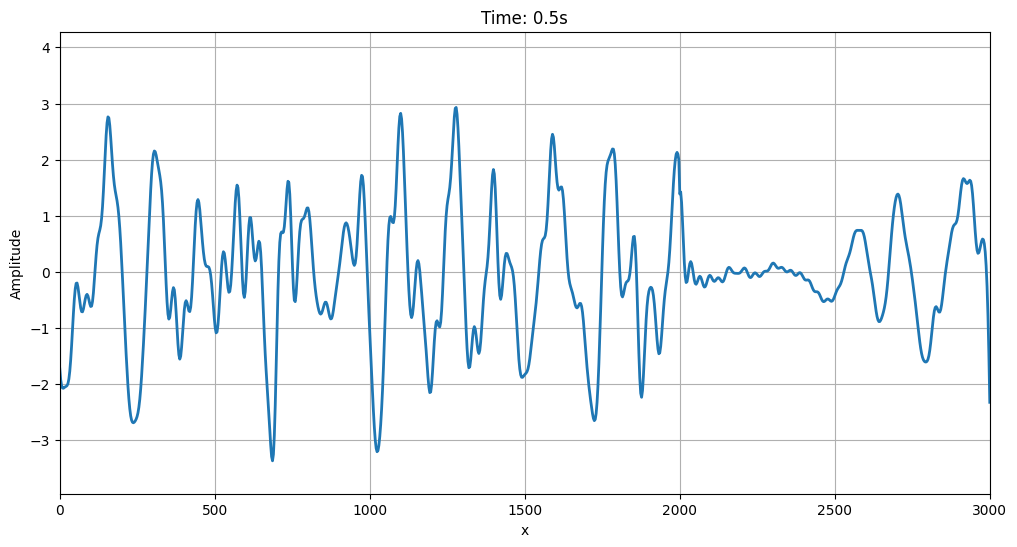

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np 

fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot([], [], lw=2)

ax.set_xlim(x[0], x[-1])
ax.set_ylim(np.min(saved_data[0]), np.max(saved_data[0]))
ax.set_xlabel("x")
ax.set_ylabel("Amplitude")
ax.set_title("Wave evolution over time")
ax.grid(True)

def update(frame):
    ax.set_title(f"Time: {saved_time[frame]:.1f}s")

    y = saved_data[0, frame, :]
    line.set_data(x, y)
    return line,

ani = animation.FuncAnimation(fig, update, frames=saved_data.shape[1], blit=True)
ani.save("wave_animation.gif", writer='pillow', fps=15)

In [131]:
for i in range(6+14):
    for j in range(400):
        y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

    if i < 6:
        eta = irfft(y_hat[:y_hat.shape[0]//2])
        
        eta_obs = X_train_local[i+1, :]
        eta_obs[cut_index:] = eta[cut_index:]
        eta_hat_obs = rfft(eta_obs)

        X_train_local[i+1, :] = eta_obs # new

        y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
        y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

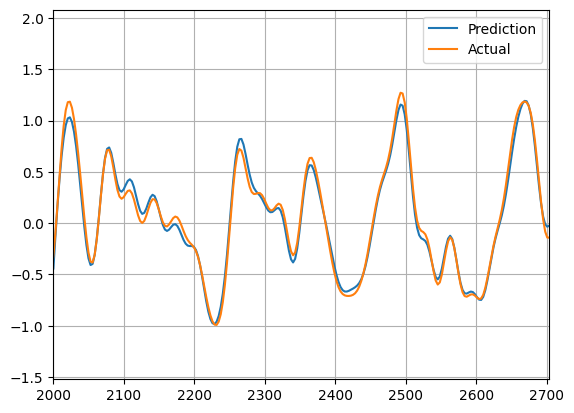

MAE: 0.054
RMSE: 0.065


'\nit = 0\n    MAE: 0.091\n    RMSE: 0.111\nit = 1\n    MAE: 0.074\n    RMSE: 0.093\nit = 2\n    MAE: 0.071\n    RMSE: 0.086\nit = 3\n    MAE: 0.068\n    RMSE: 0.081\nit = 4\n    MAE: 0.065\n    RMSE: 0.077\nit = 5\n    MAE: 0.063\n    RMSE: 0.074\nit = 6:\n    MAE: 0.061\n    RMSE: 0.072\nit = 7:\n    MAE: 0.059\n    RMSE: 0.069\nit = 8:\n    MAE: 0.057\n    RMSE: 0.068\nit = 9:\n    MAE: 0.055\n    RMSE: 0.066\n\n\nfno\n    MAE: 0.062\n    RMSE: 0.080\n'

In [ ]:
eta_pred = irfft(y_hat[:y_hat.shape[0]//2])
plt.plot(x, eta_pred, label="Prediction")
plt.plot(x, y_train[index, :], label="Actual")
plt.xlim(x[cut_index], x[cut_index_2])
plt.legend()
plt.grid()
plt.show()

error = eta_pred[cut_index:cut_index_2] - y_train[index, cut_index:cut_index_2]

print(f"MAE: {np.mean(np.abs(error)):.5e}")
print(f"RMSE: {np.sqrt(np.mean(error**2)):.5e}")

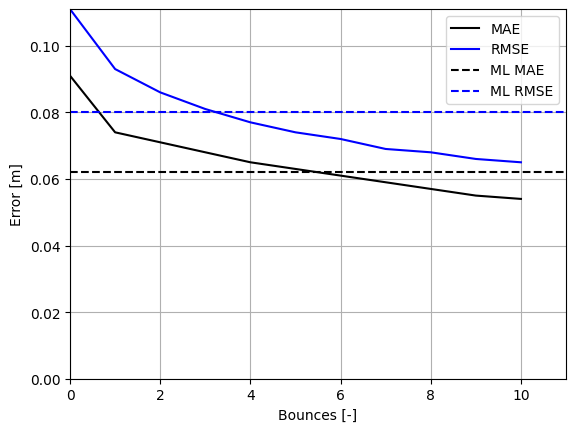

In [144]:
mae = [0.091, 0.074, 0.071, 0.068, 0.065, 0.063, 0.061, 0.059, 0.057, 0.055, 0.054]
rmse = [0.111, 0.093, 0.086, 0.081, 0.077, 0.074, 0.072, 0.069, 0.068, 0.066, 0.065]

plt.plot(mae, label="MAE", color="k")
plt.plot(rmse, label="RMSE", color="b")
plt.ylim(0, rmse[0])
plt.xlim(0, len(mae))
plt.grid()
plt.xlabel("Bounces [-]")
plt.ylabel("Error [m]")

plt.axhline(y=0.062, label="ML MAE", color="k", linestyle="--")
plt.axhline(y=0.080, label="ML RMSE", color="b", linestyle="--")
plt.legend()
plt.show()

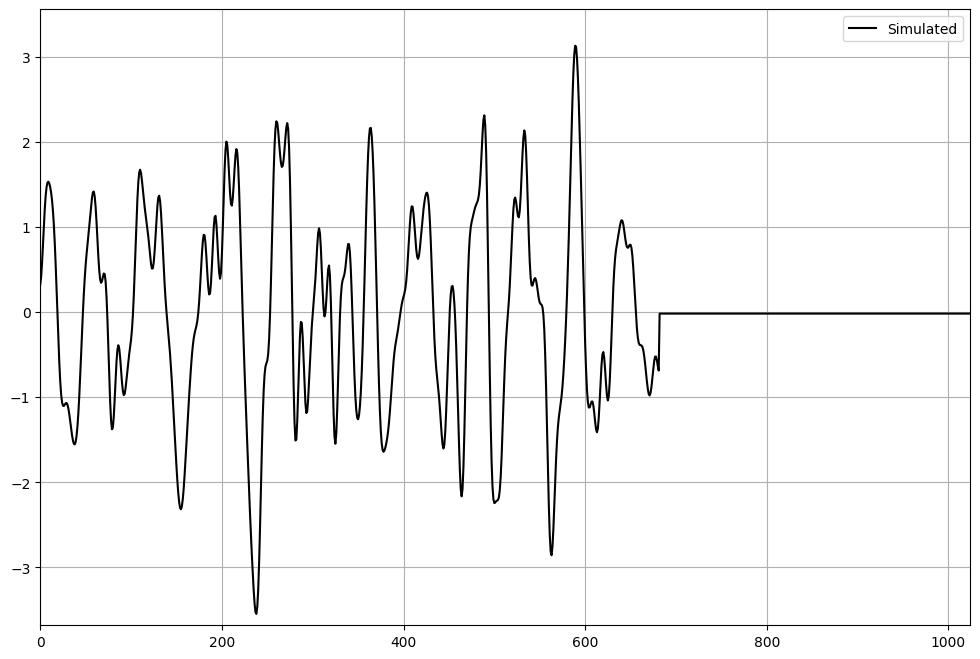

In [37]:
import matplotlib.animation as animation

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

x = np.arange(eta_saved.shape[1])

fig, ax = plt.subplots(figsize=(12, 8))
line, = ax.plot([], [], 'k', label="Simulated")

ax.set_xlim(0, eta_saved.shape[1])
ax.set_ylim(np.min(eta_saved), np.max(eta_saved))
ax.grid(True)
ax.legend()

def update(frame):
    line.set_data(x, eta_saved[frame])
    return line,

ani = animation.FuncAnimation(fig, update, frames=eta_saved.shape[0], blit=True)
ani.save("wave_simulation.gif", writer='pillow', fps=10)